Reading: /kaggle/input/dynact-dataset/reaction_dataset.csv


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,type,metal,state,index,is_ts,energy_eV,Z,period,group,EN,E_ads_H
0,pathway,Ni,*C2H4,0.0,0.0,-1.20,NaN,NaN,NaN,NaN,NaN
1,pathway,Ni,TS1,1.0,1.0,-0.85,NaN,NaN,NaN,NaN,NaN
2,pathway,Ni,*C2H5,2.0,0.0,-1.00,NaN,NaN,NaN,NaN,NaN
3,pathway,Ni,TS2,3.0,1.0,-0.60,NaN,NaN,NaN,NaN,NaN
4,pathway,Ni,*C2H6,4.0,0.0,-0.70,NaN,NaN,NaN,NaN,NaN


Shape: (27, 11)
Ni — Energy span: 0.80 eV (TDTS idx 5, TDI idx 0)


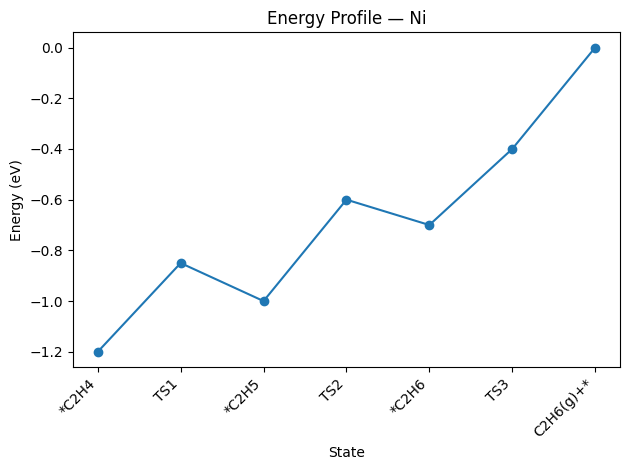

Ni: energy span = 0.80 eV
Pd: energy span = 0.70 eV


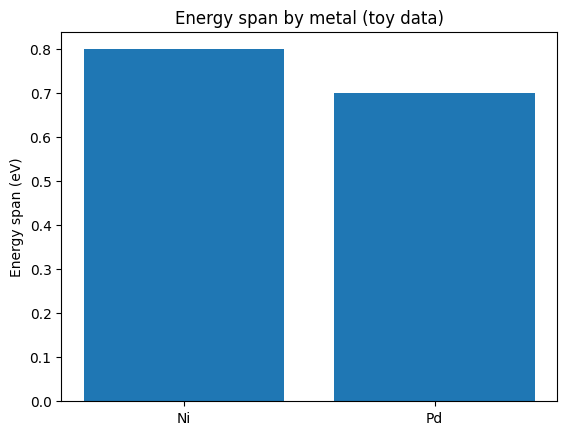


Linear Regression
MAE: 0.09034419223662925
R2 : 0.6336400493752958

Random Forest
MAE: 0.05284166666666715
R2 : 0.7874545464516821


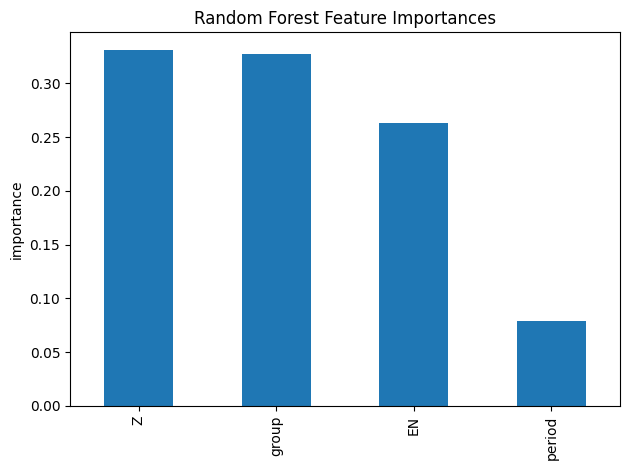

In [8]:
# DYNACAT — Reaction Network + ML (Kaggle-ready)
# Works with 'dynacat_dataset.csv' uploaded as a Kaggle dataset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob, os

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# -----------------------------
# Locate and load the dataset
# -----------------------------
# Try to auto-find the CSV under /kaggle/input
candidates = glob.glob("/kaggle/input/**/reaction_dataset.csv", recursive=True)
if len(candidates) == 0:
    # Fallback: EDIT this to your dataset path if needed
    # Example: "/kaggle/input/reaction-dataset/reaction_dataset.csv"
    csv_path = "/kaggle/input/dynacat-dataset/reaction_dataset.csv"
else:
    csv_path = candidates[0]

print("Reading:", csv_path)
df = pd.read_csv(csv_path)
display(df.head())
print("Shape:", df.shape)

# Basic sanity check: should be 11 columns
assert df.shape[1] == 11, f"Expected 11 columns, got {df.shape[1]}"

# -----------------------------
# Reaction Network: Energy Span
# -----------------------------
def energy_span(states, is_ts):
    """Simple energy span (Kozuch–Shaik style for a linear sequence)."""
    best_span, tdts_idx, tdi_idx = -1e9, None, None
    states = list(states)
    is_ts = list(is_ts)
    for i, (E, ts) in enumerate(zip(states, is_ts)):
        if ts != 1: 
            continue
        min_prev, min_idx = None, None
        for j in range(i):
            if is_ts[j] == 0:
                if min_prev is None or states[j] < min_prev:
                    min_prev, min_idx = states[j], j
        if min_prev is None: 
            continue
        span = E - min_prev
        if span > best_span:
            best_span, tdts_idx, tdi_idx = span, i, min_idx
    return best_span, tdts_idx, tdi_idx

def plot_profile(subset, metal):
    x = subset["index"].to_numpy()
    y = subset["energy_eV"].to_numpy()
    labels = subset["state"].to_list()
    plt.figure()
    plt.plot(x, y, marker="o")
    plt.xticks(x, labels, rotation=45, ha="right")
    plt.xlabel("State")
    plt.ylabel("Energy (eV)")
    plt.title(f"Energy Profile — {metal}")
    plt.tight_layout()
    plt.show()

# Example profile for Ni
path_df = df[df["type"]=="pathway"].copy()
ni = path_df[path_df["metal"]=="Ni"].sort_values("index")
Espan, tdts, tdi = energy_span(ni["energy_eV"], ni["is_ts"])
print(f"Ni — Energy span: {Espan:.2f} eV (TDTS idx {tdts}, TDI idx {tdi})")
plot_profile(ni, "Ni")

# Compare metals
metals = path_df["metal"].unique()
spans = []
for m in metals:
    sub = path_df[path_df["metal"]==m].sort_values("index")
    e, tdts, tdi = energy_span(sub["energy_eV"], sub["is_ts"])
    spans.append((m, e))
    print(f"{m}: energy span = {e:.2f} eV")

# Bar chart of energy spans
plt.figure()
plt.bar([m for m,_ in spans], [e for _,e in spans])
plt.ylabel("Energy span (eV)")
plt.title("Energy span by metal (toy data)")
plt.show()

# -----------------------------
# ML: Predict H Adsorption Energy
# -----------------------------
ads = df[df["type"]=="adsorption"].copy()

# Ensure numeric dtypes for features/target
for col in ["Z","period","group","EN","E_ads_H"]:
    ads[col] = pd.to_numeric(ads[col])

X = ads[["Z","period","group","EN"]]
y = ads["E_ads_H"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

# Linear Regression
lin = LinearRegression().fit(X_train, y_train)
pred_lin = lin.predict(X_test)
print("\nLinear Regression")
print("MAE:", mean_absolute_error(y_test, pred_lin))
print("R2 :", r2_score(y_test, pred_lin))

# Random Forest
rf = RandomForestRegressor(n_estimators=300, random_state=42).fit(X_train, y_train)
pred_rf = rf.predict(X_test)
print("\nRandom Forest")
print("MAE:", mean_absolute_error(y_test, pred_rf))
print("R2 :", r2_score(y_test, pred_rf))

# Feature importances
imp = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure()
imp.plot(kind="bar")
plt.title("Random Forest Feature Importances")
plt.ylabel("importance")
plt.tight_layout()
plt.show()
